# Lesson 6: Essay Writer

In [30]:
from dotenv import load_dotenv

_ = load_dotenv()

In [31]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory_cm = SqliteSaver.from_conn_string(":memory:")
memory = memory_cm.__enter__()

In [32]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int
    draft_html: str

In [33]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(
    model="gpt-5-mini", 
    temperature=0,
    timeout=60,
    max_retries=2,
)

In [34]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [35]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [36]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [37]:
RESEARCH_PLAN_PROMPT = """Generate 1–3 web search queries to research the topic.

Rules:
- Each query MUST be <= 120 characters.
- Keyword-style only (no paragraphs).
- No copying the user prompt verbatim.
Return only the queries.
"""

In [38]:
RESEARCH_CRITIQUE_PROMPT = """You are generating web search queries to find facts and examples that help revise an essay.

Rules:
- Return 1 to 3 queries.
- Each query MUST be <= 120 characters.
- Queries must be keyword-style (no long sentences).
- Do NOT copy text from the critique verbatim.
- Focus on definitions, comparisons, examples, counterarguments, and credible sources.
"""



In [39]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [40]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [41]:
MAX_TAVILY_QUERY_LEN = 400

def safe_tavily_query(q: str) -> str:
    q = " ".join(q.split())  # collapse whitespace
    return q[:MAX_TAVILY_QUERY_LEN]


In [42]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [43]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        q = safe_tavily_query(q)
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [44]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [45]:
import html
import re

def format_node(state: AgentState):
    draft = state.get("draft", "")
    # Escape anything the model might have output as HTML
    safe = html.escape(draft)

    # Split into paragraphs on blank lines
    paras = [p.strip() for p in re.split(r"\n\s*\n", safe) if p.strip()]

    # Basic pretty formatting
    body = "\n".join(f"<p>{p}</p>" for p in paras)

    wrapped = f"""
    <div style="
        max-width: 800px;
        margin: 0 auto;
        padding: 16px 20px;
        background: white;
        border: 1px solid #eee;
        border-radius: 12px;
        box-shadow: 0 2px 10px rgba(0,0,0,0.05);
        font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial;
        line-height: 1.6;
        font-size: 16px;">
      {body}
    </div>
    """

    return {"draft_html": wrapped}


In [46]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [47]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(
            content="Key critique points:\n"
            + "\n".join(state["critique"].splitlines()[:6])
        )
    ])
    content = state['content'] or []
    for q in queries.queries:
        q = safe_tavily_query(q)
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [48]:
def should_continue(state: AgentState):
    if state["revision_number"] > state["max_revisions"]:
        return "format"   # stop: go format then END
    return "reflect"      # continue revising

In [49]:
builder = StateGraph(AgentState)

In [50]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("format", format_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [51]:
builder.set_entry_point("planner")

In [52]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {"reflect": "reflect", "format": "format"}
)

In [53]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("format", END)
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [54]:
graph = builder.compile(checkpointer=memory)

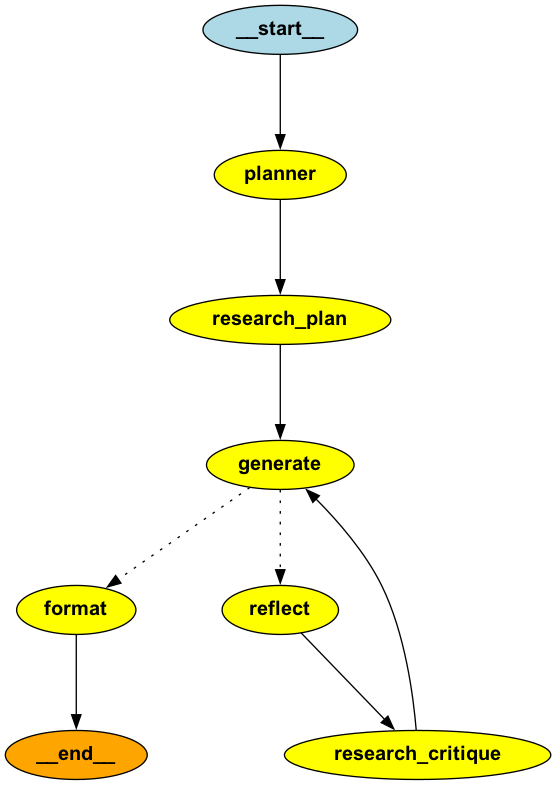

In [55]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [56]:
from IPython.display import HTML, display

thread = {"configurable": {"thread_id": "1"}}

for s in graph.stream(
    {
        "task": "what is the difference between langchain and langgraph",
        "max_revisions": 2,
        "revision_number": 1,
        "content": [],
    },
    thread,
):
    if "format" in s:
        html_str = s["format"].get("draft_html")   # <-- rename variable
        if html_str:
            display(HTML(html_str))
        else:
            print(s)
    else:
        print(s)

{'planner': {'plan': 'Title suggestion: "LangChain vs. LangGraph: Comparing Two Approaches to Building LLM Applications"\n\nThesis (to include in introduction)\n- In one succinct sentence, state the central comparison: e.g., “LangChain and LangGraph represent two different design philosophies for constructing LLM-powered applications — LangChain emphasizes programmatic, chain/agent-driven composition and developer control, while LangGraph emphasizes graph-based workflow orchestration and visual/graph-native composition.” (Adjust after current fact-checking of LangGraph features.)\n\nOutline (high-level essay structure with notes/instructions)\n\n1. Introduction (150–250 words)\n   - Purpose: Introduce both tools at a high level and state why their comparison matters.\n   - Include a one-sentence thesis (see above).\n   - Notes/instructions:\n     - Define target audience (developers, architects, product managers).\n     - Mention the broader context: rise of LLM usage, need for orchest

## Essay Writer Interface

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [ ]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()